In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import datasets, transforms
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import random
from PIL import Image, ImageEnhance
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim.lr_scheduler import StepLR
from torchvision.models import ResNet50_Weights
from skimage import color
import torch.nn.functional as F
from sklearn.model_selection import ShuffleSplit, LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
import copy
import torch.nn.init as init

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class_mapping = {
    0: 1,
    1: 3,
    2: 0,
    3: 2
}

train_dir = r"D:\6. OAI HCMC 2025\aio-hutech\train"
test_dir = r"D:\6. OAI HCMC 2025\aio-hutech-\test-label"

# Custom color space transformation
class ColorSpaceTransform:
    def __init__(self, p=0.3):
        self.p = p
    
    def __call__(self, img):
        if random.random() < self.p:
            img_np = np.array(img)
            
            # Choose one or more transformations
            transform_type = random.choice(['hsv', 'lab', 'ycbcr'])
            
            if transform_type == 'hsv':
                transformed = color.rgb2hsv(img_np)
                hue_shift = np.random.uniform(-0.1, 0.1)
                saturation_shift = np.random.uniform(0.8, 1.2)
                transformed[:, :, 0] = (transformed[:, :, 0] + hue_shift) % 1.0
                transformed[:, :, 1] = np.clip(transformed[:, :, 1] * saturation_shift, 0, 1)
                transformed = color.hsv2rgb(transformed)
                
            elif transform_type == 'lab':
                transformed = color.rgb2lab(img_np)
                lightness_shift = np.random.uniform(0.8, 1.2)
                transformed[:, :, 0] = np.clip(transformed[:, :, 0] * lightness_shift, 0, 100)
                transformed = color.lab2rgb(transformed)
                
            elif transform_type == 'ycbcr':
                transformed = color.rgb2ycbcr(img_np)
                transformed = color.ycbcr2rgb(transformed)
            
            # Convert back to PIL
            transformed = np.clip(transformed * 255, 0, 255).astype(np.uint8)
            return Image.fromarray(transformed)
        
        return img

# Mushroom-specific augmentation - adjusted for smaller images
class MushroomSpecificAugment:
    def __init__(self, p=0.4):
        self.p = p
    
    def __call__(self, img):
        if random.random() < self.p:
            img_np = np.array(img)
            
            if len(img_np.shape) != 3 or img_np.shape[2] != 3:
                return img
                
            h, w, c = img_np.shape
            
            # Modify top part (mushroom cap)
            top_region = img_np[:h//3, :, :]
            
            # Color augmentation
            hue_shift = np.random.uniform(-0.1, 0.1)
            saturation_shift = np.random.uniform(0.8, 1.2)
            top_hsv = color.rgb2hsv(top_region)
            top_hsv[:, :, 0] = (top_hsv[:, :, 0] + hue_shift) % 1.0
            top_hsv[:, :, 1] = np.clip(top_hsv[:, :, 1] * saturation_shift, 0, 1)
            top_region_new = color.hsv2rgb(top_hsv)
            
            img_np[:h//3, :, :] = np.clip(top_region_new * 255, 0, 255).astype(np.uint8)

            # Add noise
            if random.random() < 0.2:
                noise = np.random.normal(0, 5, size=top_region.shape).astype(np.uint8)
                img_np[:h//3, :, :] = np.clip(top_region + noise, 0, 255)

            # Random erase part of the mushroom cap
            if random.random() < 0.3:
                erase_h = np.random.randint(5, h//3)
                erase_w = np.random.randint(5, w)
                img_np[:erase_h, :erase_w, :] = 0  # Erasing the cap

            return Image.fromarray(img_np)
        return img

class MushroomDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.samples = []
        self.classes = []
        self.class_to_idx = {}

        if not os.path.exists(root_dir):
            print(f"Warning: Directory {root_dir} does not exist.")
            return
        try:
            items = os.listdir(root_dir)
            if self.is_test or any(item.lower().endswith(('.png', '.jpg', '.jpeg')) for item in items):
                self._setup_test_dataset(root_dir)
            else:
                self._setup_train_dataset(root_dir)
        except Exception as e:
            print(f"Error setting up dataset: {e}")
            self.classes = ["unknown"]
            self.class_to_idx = {"unknown": 0}

    def _setup_test_dataset(self, root_dir):
        """Setup dataset for test directory (direct images without class subdirectories)"""
        self.classes = ["unknown"]  # For testing, we don't know the class
        self.class_to_idx = {"unknown": 0}

        for img_name in os.listdir(root_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root_dir, img_name)
                if os.path.isfile(img_path):
                    self.samples.append((img_path, -1))  # Use -1 for test set

    def _setup_train_dataset(self, root_dir):
        """Setup dataset for training directory (with class subdirectories)"""
        self.classes = sorted([d for d in os.listdir(root_dir)
                              if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = torch.zeros((3, 32, 32))  # Placeholder sized for 32x32 images
            return placeholder, label

# Enhanced dataset with multiple augmentations per image
class MultiAugmentDataset(Dataset):
    def __init__(self, dataset, num_copies=3):
        self.dataset = dataset
        self.num_copies = num_copies
        
    def __len__(self):
        return len(self.dataset) * self.num_copies
    
    def __getitem__(self, idx):
        real_idx = idx % len(self.dataset)
        image, label = self.dataset[real_idx]
        # Each copy will have different (random) augmentations
        return image, label

# Function to calculate mean and std
def calculate_mean_std(dataset, batch_size=512):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, 3, -1)  # Flatten the images to shape (batch_size, 3, H*W)
        mean += images.mean(2).mean(0)  # Mean over height and width
        std += images.std(2).std(0)    # Std over height and width
    mean /= len(loader)
    std /= len(loader)
    return mean, std

mean, std = calculate_mean_std(MushroomDataset(train_dir, transform=transforms.ToTensor()), batch_size=512)

# Enhanced training transforms optimized for 32x32 images
enhanced_train_transform = transforms.Compose([
    # No initial resize needed as images are already 32x32
    
    # Geometric transformations - reduced scales for small images
    transforms.RandomResizedCrop(32, scale=(0.7, 1.0)),  # Keep close to original size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),  # Lower probability for vertical flip
    transforms.RandomRotation(degrees=30),  # Reduced rotation angle
    transforms.RandomAffine(degrees=10, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),  # Gentler transformations
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Reduced distortion
    
    # Color transformations
    transforms.RandomGrayscale(p=0.1),  # Lower probability for grayscale
    transforms.RandomSolarize(threshold=128, p=0.1),  # Lower probability for solarize
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),  # Gentler color jitter
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),  # Reduced sharpness
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Smaller kernel for small images
    
    # Custom mushroom-specific transforms
    MushroomSpecificAugment(p=0.3),  # Reduced probability
    ColorSpaceTransform(p=0.2),  # Reduced probability
    
    # Final processing
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),  # Smaller erasing regions
    transforms.Normalize(mean.tolist(), std.tolist())
])

# Simplified evaluation transform for 32x32 images
eval_transform = transforms.Compose([
    # No resize needed as images are already 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

def setup_data_loaders(train_dir, test_dir, batch_size=512, val_split=0.2, use_multi_augment=True):
    """Setup the data loaders for training, validation, and testing with enhanced augmentation"""

    print("Setting up training and test datasets with enhanced augmentation for 32x32 images...")

    if not os.path.exists(train_dir):
        print(f"Warning: Training directory {train_dir} does not exist!")
        os.makedirs(train_dir, exist_ok=True)

    # Create base dataset
    train_dataset = MushroomDataset(train_dir, transform=enhanced_train_transform)
    
    # Apply multi-augmentation if requested
    if use_multi_augment:
        print("Using multi-augmentation strategy (5 copies of each image with different augmentations)")
        train_dataset = MultiAugmentDataset(train_dataset, num_copies=5)  
    
    # Create validation split
    train_size = int((1 - val_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size

    train_dataset, valid_dataset = random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create test dataset
    test_dataset = MushroomDataset(test_dir, transform=eval_transform, is_test=True)

    # Create data loaders - using fewer workers for small images
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(valid_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return train_loader, valid_loader, test_loader

trainloader, valloader, testloader = setup_data_loaders(
    train_dir, 
    test_dir,
    batch_size=512,  # Increased batch size for smaller images
    val_split=0.2,  # 20% for validation
    use_multi_augment=True
)

Setting up training and test datasets with enhanced augmentation for 32x32 images...
Using multi-augmentation strategy (5 copies of each image with different augmentations)
Training samples: 4800
Validation samples: 1200
Test samples: 200


In [4]:
class vgg16_model(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super().__init__()
        self.num_classes = num_classes
        
        vgg16 = models.vgg16(pretrained=pretrained)

        self.features = vgg16.features

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),  
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)  
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

In [5]:
class efficientnetb6_model(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super().__init__()
        self.num_classes = num_classes

        self.efficientnetb6 = models.efficientnet_b6(weights=models.EfficientNet_B6_Weights.IMAGENET1K_V1 if pretrained else None)

        self.features = nn.Sequential(*list(self.efficientnetb6.features.children()))

        num_features = self.efficientnetb6.classifier[1].in_features  
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.features(x)
        pooled = self.efficientnetb6.avgpool(features)
        x = torch.flatten(pooled, 1)
        x = self.classifier(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def mutual_traininng_model_v3(model1=efficientnetb6_model(4), model2=vgg16_model(4), model3=vgg16_model(4), 
                            train_loader=trainloader, valid_loader=valloader, 
                            num_epochs=15, learning_rate=0.001, device='cuda'):
    
    # Ensure models are on the correct device
    model1 = model1.to(device)
    model2 = model2.to(device)
    model3 = model3.to(device)

    # Define loss function and optimizers
    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

    # Optimizers for each model
    model1_optimizer = optim.AdamW(model1.parameters(), lr=learning_rate, weight_decay=0.01)
    model2_optimizer = optim.AdamW(model2.parameters(), lr=learning_rate, weight_decay=0.01)
    model3_optimizer = optim.AdamW(model3.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # Scheduler for learning rate
    scheduler_model1 = optim.lr_scheduler.OneCycleLR(
        model1_optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,
        div_factor=25,
        final_div_factor=1000,
        anneal_strategy='cos'
    )

    best_val_acc = 0.0
    patience = 7
    counter = 0

    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model1.train()
        model2.train()
        model3.train()

        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clear gradients
            model1_optimizer.zero_grad()
            model2_optimizer.zero_grad()
            model3_optimizer.zero_grad()

            # Mutual learning: outputs from all three models
            with torch.cuda.amp.autocast():
                model1_outputs = model1(inputs)
                model2_outputs = model2(inputs)
                model3_outputs = model3(inputs)

                # Softmax outputs to get pseudo-labels
                soft_labels_from_model2 = torch.softmax(model2_outputs.detach(), dim=1)
                soft_labels_from_model1 = torch.softmax(model1_outputs.detach(), dim=1)
                soft_labels_from_model3 = torch.softmax(model3_outputs.detach(), dim=1)

                # Compute loss for model1, model2, and model3 with mutual learning 
                model1_loss = criterion(model1_outputs, labels) + 0.5 * torch.mean(
                    torch.sum(-soft_labels_from_model2 * torch.log_softmax(model1_outputs, dim=1), dim=1)
                ) + 0.5 * torch.mean(
                    torch.sum(-soft_labels_from_model3 * torch.log_softmax(model1_outputs, dim=1), dim=1)
                )

                model2_loss = criterion(model2_outputs, labels) + 0.5 * torch.mean(
                    torch.sum(-soft_labels_from_model1 * torch.log_softmax(model2_outputs, dim=1), dim=1)
                ) + 0.5 * torch.mean(
                    torch.sum(-soft_labels_from_model3 * torch.log_softmax(model2_outputs, dim=1), dim=1)
                )

                model3_loss = criterion(model3_outputs, labels) + 0.5 * torch.mean(
                    torch.sum(-soft_labels_from_model1 * torch.log_softmax(model3_outputs, dim=1), dim=1)
                ) + 0.5 * torch.mean(
                    torch.sum(-soft_labels_from_model2 * torch.log_softmax(model3_outputs, dim=1), dim=1)
                )

            # Backpropagation
            scaler.scale(model1_loss).backward()
            scaler.scale(model2_loss).backward()
            scaler.scale(model3_loss).backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1.0)

            # Optimizer step
            scaler.step(model1_optimizer)
            scaler.step(model2_optimizer)
            scaler.step(model3_optimizer)
            scaler.update()

            # Calculate training accuracy
            _, preds = torch.max(model1_outputs, 1)
            running_loss += model1_loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validate the models
        model1.eval()
        model2.eval()
        model3.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total_samples = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Get outputs from all models
                model1_outputs = model1(inputs)
                model2_outputs = model2(inputs)
                model3_outputs = model3(inputs)

                # Calculate predictions from all models
                model1_preds = torch.argmax(model1_outputs, dim=1)
                model2_preds = torch.argmax(model2_outputs, dim=1)
                model3_preds = torch.argmax(model3_outputs, dim=1)

                # Calculate the loss for model1
                loss = criterion(model1_outputs, labels)

                # Calculate total validation loss and correct predictions
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(model1_preds == labels.data).item()
                val_total_samples += inputs.size(0)

        val_epoch_loss = val_running_loss / val_total_samples
        val_epoch_acc = val_running_corrects / val_total_samples
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc*100:.2f}% - Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc*100:.2f}%")
        
        scheduler_model1.step()
        # scheduler_model2.step()
        # scheduler_model3.step()
        
        # Save the best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model1.state_dict(), 'best_modelv1.pth')
            torch.save(model2.state_dict(), 'best_modelv2.pth')
            torch.save(model3.state_dict(), 'best_modelv3.pth')
            print(f"Saved best models with validation accuracy: {best_val_acc*100:.4f}")
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')
    plt.savefig('training_history.png')
    plt.show()

    return model1, model2, model3

c:\Users\LENOVO\anaconda3\envs\oai-hutech\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\oai-hutech\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def predict_and_create_submission_ensemble(models, test_loader, class_mapping, filename='submission.csv'):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for i, model in enumerate(models):
        models[i] = model.to(device)
        models[i].eval()
        print(f"Model {i+1} running on: {next(models[i].parameters()).device}")

    all_preds = []
    all_mapped_preds = []  
    all_filenames = []

    try:
        test_dataset = test_loader.dataset
        for i in range(len(test_dataset)):
            if hasattr(test_dataset, 'samples') and i < len(test_dataset.samples):
                img_path = test_dataset.samples[i][0]
                filename_only = os.path.basename(img_path)
                all_filenames.append(filename_only)
            else:
                all_filenames.append(f"test_image_{i}.jpg")
    except Exception as e:
        print(f"Warning: Couldn't extract filenames from test dataset: {e}")
        all_filenames = [f"test_image_{i}.jpg" for i in range(len(test_loader.dataset))]

    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(test_loader):
            inputs = inputs.to(device)
            
            batch_preds = []
            for model in models:
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1) 
                batch_preds.append(probs)

            ensemble_probs = sum(batch_preds) / len(models)
            _, preds = torch.max(ensemble_probs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            
            if batch_idx % 10 == 0:
                print(f"Processed {batch_idx}/{len(test_loader)} batches")

    for p in all_preds:
        if p in class_mapping:
            all_mapped_preds.append(class_mapping[p])
        else:
            print(f"Warning: Prediction {p} not found in class_mapping. Using raw prediction.")
            all_mapped_preds.append(p)

    formatted_ids = [os.path.splitext(fname)[0] for fname in all_filenames]

    submission_df = pd.DataFrame({
        'id': formatted_ids,
        'label': all_mapped_preds
    })

    print("\nSubmission sample (BEFORE saving):")
    print(submission_df.head(10))

    submission_df.to_csv(filename, index=False)
    print(f"Submission file created: {filename}")

    print("\nVerifying saved file by reading it back:")
    try:
        saved_df = pd.read_csv(filename)
        print("Sample from saved file:")
        print(saved_df.head(10))

        if not submission_df.equals(saved_df):
            print("WARNING: The saved file differs from the generated predictions!")
            diff_mask = submission_df != saved_df
            diff_indices = diff_mask.any(axis=1)
            if diff_indices.any():
                print("Differences found at rows:")
                print(submission_df[diff_indices].compare(saved_df[diff_indices]))
    except Exception as e:
        print(f"Error verifying saved file: {e}")

    return submission_df

In [9]:
def calculate_accuracy(csv_path):
    df = pd.read_csv(csv_path)
    expected_labels = []
    expected_labels.extend([1] * 50)  
    expected_labels.extend([2] * 50) 
    expected_labels.extend([3] * 50) 
    expected_labels.extend([0] * 50)  
    
    actual_labels = df['label'].tolist()
    
    n = min(len(actual_labels), len(expected_labels))
    
    correct = sum(1 for i in range(n) if actual_labels[i] == expected_labels[i])
    
    accuracy = (correct / n) * 100
    
    return accuracy

In [ ]:
def mainingfull_programming(): 
    torch.manual_seed(42)
    np.random.seed(42)
    
    print(f"\nCreating hypermodel-mutual-training models with {4} classes...")
    model1 = efficientnetb6_model(num_classes=4).to(device)
    model2 = vgg16_model(num_classes=4).to(device)
    model3 = vgg16_model(num_classes=4).to(device)
    
    print("\n=== Starting model training ===")
    
    trained_model, trained_aux1, trained_aux2 = mutual_traininng_model_v3(
        model1=model1,
        model2=model1,
        model3=model1,
        train_loader=trainloader,
        valid_loader=valloader,
        num_epochs=250,
        learning_rate=0.001
    )
    
    print("Training completed!")
     
    print("\n=== Making predictions on test data using ensemble of models ===")
    
    model1.load_state_dict(torch.load('best_modelv1.pth'))
    model2.load_state_dict(torch.load('best_modelv2.pth'))
    model3.load_state_dict(torch.load('best_modelv3.pth'))

    submission_df = predict_and_create_submission_ensemble(
        models=[model1, model2, model3],
        test_loader=testloader,
        class_mapping=class_mapping,
        filename='submission-dml-e-v96.csv',
    )
    
    print("Test accuracy: ", calculate_accuracy(r"D:\6. OAI HCMC 2025\aio-hutech-\submission-dml-e-v96.csv"))

    print("\n=== Process completed successfully! ===")


Creating hypermodel-mutual-training models with 4 classes...

=== Starting model training ===


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24752\307943201.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24752\307943201.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/250 - Train Loss: 2.7772, Train Accuracy: 25.87% - Val Loss: 1.3892, Val Accuracy: 24.33%
Saved best models with validation accuracy: 24.3333
Epoch 2/250 - Train Loss: 2.7747, Train Accuracy: 26.27% - Val Loss: 1.3879, Val Accuracy: 24.33%
Epoch 3/250 - Train Loss: 2.7728, Train Accuracy: 27.10% - Val Loss: 1.3882, Val Accuracy: 24.33%
Epoch 4/250 - Train Loss: 2.7706, Train Accuracy: 27.85% - Val Loss: 1.3888, Val Accuracy: 24.42%
Saved best models with validation accuracy: 24.4167
Epoch 5/250 - Train Loss: 2.7660, Train Accuracy: 29.31% - Val Loss: 1.3906, Val Accuracy: 24.50%
Saved best models with validation accuracy: 24.5000
Epoch 6/250 - Train Loss: 2.7632, Train Accuracy: 30.25% - Val Loss: 1.3931, Val Accuracy: 24.25%
Epoch 7/250 - Train Loss: 2.7617, Train Accuracy: 30.85% - Val Loss: 1.3942, Val Accuracy: 27.17%
Saved best models with validation accuracy: 27.1667
Epoch 8/250 - Train Loss: 2.7592, Train Accuracy: 31.31% - Val Loss: 1.3954, Val Accuracy: 25.58%
Epoch 9/

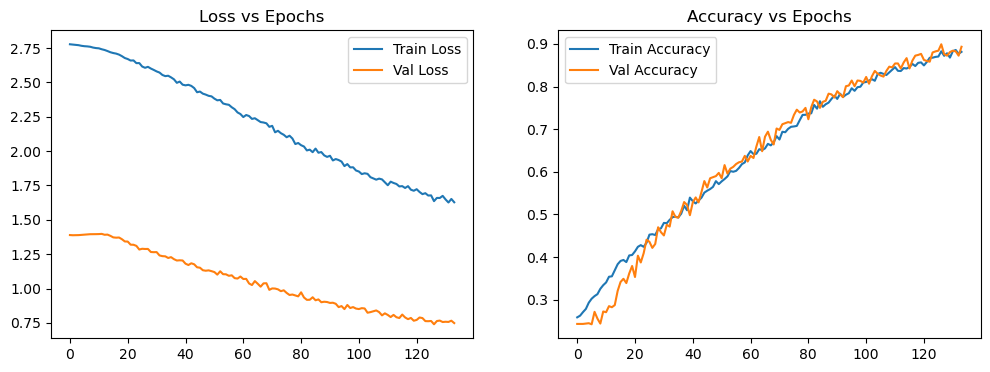

Training completed!

=== Making predictions on test data using ensemble of models ===


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24752\1340472431.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_modelv1.pth'))
C:\U

Getting predictions from each model...
Collected predictions from model 1
Collected predictions from model 2
Collected predictions from model 3
Starting grid search for optimal weights...
Searching through 501501 weight combinations...
New best: Weights=[np.float64(0.0), np.float64(0.0), np.float64(1.0)], Accuracy=91.5000%
New best: Weights=[np.float64(0.0), np.float64(0.038), np.float64(0.962)], Accuracy=92.0000%
Processed 100/501501 combinations
New best: Weights=[np.float64(0.0), np.float64(0.176), np.float64(0.824)], Accuracy=92.5000%
Processed 200/501501 combinations
New best: Weights=[np.float64(0.0), np.float64(0.27), np.float64(0.73)], Accuracy=93.0000%
Processed 300/501501 combinations
New best: Weights=[np.float64(0.0), np.float64(0.331), np.float64(0.669)], Accuracy=93.5000%
New best: Weights=[np.float64(0.0), np.float64(0.34500000000000003), np.float64(0.655)], Accuracy=94.0000%
New best: Weights=[np.float64(0.0), np.float64(0.37), np.float64(0.63)], Accuracy=94.5000%
Proce

KeyboardInterrupt: 

In [ ]:
mainingfull_programming()